In [1]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend
from tensorflow.keras import layers

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

from datetime import datetime

from tqdm.auto import tqdm

import IPython
from IPython import display
import ipywidgets as widgets

import ngraph_bridge
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.tools import freeze_graph
import json

from numpy.random import seed
from tensorflow import set_random_seed

def reset_seed():
    # Making results reproducible
    seed(10092)
    set_random_seed(10093)  

import urllib
import xml
import re
from function_approximations import *

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

In [2]:
# Retrieve list of categories.

def create_dir(dirname):
    try:
        # Create target Directory
        os.mkdir(dirname)
        #print("dirname " , filename ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirname ,  " already exists")

create_dir('models')
create_dir('dataset')

def list_bucket(regexp='.*'):
    """Returns a filtered list of Keys in specified GCS bucket."""
    keys = []
    fh = urllib.request.urlopen('https://storage.googleapis.com/quickdraw_dataset/')
    content = xml.dom.minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return [x[len(x) - x[::-1].find('/'):-4] for x in keys]


def retrieve(key, filename):
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy' % (urllib.parse.quote(key))
    print('URL: %s' % (url))
    open(filename, 'wb').write(urllib.request.urlopen(url).read())


def download_dataset():
    keys = list_bucket( '.*npy$')
    for key in keys:
        retrieve(key, 'dataset/' + key + '.npy')


def create_dataset(key = 'apple'):
    main_dataset = np.load('dataset/%s.npy' % (key))
    main_dataset_len = len(main_dataset)
    files = [x for x in glob.glob('dataset/*.npy') if not key in x] 
    num_files = len(files)
    elems_per_file = int(np.ceil(main_dataset_len / num_files))
    print("Main dataset has %d elements. Taking %d per dataset for a total of %d datasets" % (main_dataset_len, 
                                                                                              elems_per_file, 
                                                                                              num_files ))
    
    for file in tqdm(files):
        #print("File:", file)
        d = np.load(file)[:elems_per_file]
        main_dataset = np.concatenate([main_dataset, d])
        #print(main_dataset.shape)
    labels = np.concatenate([np.ones(main_dataset_len), np.zeros(num_files * elems_per_file)])
    T = np.concatenate([main_dataset.T, labels.reshape(1, -1)]).T
    np.save("apple_disc.npy", T)

#download_dataset()
#create_dataset(key = 'apple')

Directory  models  already exists
Directory  dataset  already exists


# Auxiliary Code

In [3]:
def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples

def load_dataset():
    T = np.load('apple_disc.npy')
    np.random.shuffle(T)
    X = T[:, :-1]
    X = X.reshape(-1, 28, 28, 1)
    Y = T[:, -1]
    print(X.shape, Y.shape)
    X = preprocess_real_samples(X)
    return X, Y

def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()


def plot_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.close()

def gen_csv(data_list, filename):
    pd.DataFrame(data_list, 
                 columns =['Epoch', 'Time (s)']).to_csv ('models/%s/times.csv'%(filename), index = False, header=True)
    

def plot_vs(x, ys, errors, title):
    fig=plt.figure(figsize=(10, 8))
    Y = ys[0]
    for y in ys:
        plt.plot(X, y[0], label=y[1])

    for y in ys[1:]:
        plt.plot(X, np.abs(Y[0] - y[0]), label='Error %s vs %s' % (Y[1], y[1]), color='crimson')
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.close()
    
def showplots(f,approxlist,a,b, names=None):
    names = ["Original"] + ["Approx. %d" % (i) for i in range(len(approxlist))] if names is None else names
    
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=(10, 8))
    plt.subplot(211)
    
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label=names[i + 1])
    plt.plot(x,f(x), label=names[0])
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.subplot(212)
    for i, vf in enumerate(vfuncs):
        plt.plot(x,f(x)-vf(x), label=names[i + 1] + " Error")
    plt.xlim(a,b)
    plt.ylabel('error = f(x)-fa(x)')
    plt.xlabel('x')
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()
    
def get_elapsed_time(tic):
    elapsed = time.time() - tic
    mins, secs = int(elapsed / 60), elapsed % 60
    hours, mins = int(mins / 60), mins % 60
    return "[%d HOURS, %02d MINS, %02d SECS]" % (hours, mins, secs)


(289468, 28, 28, 1) (289468,)


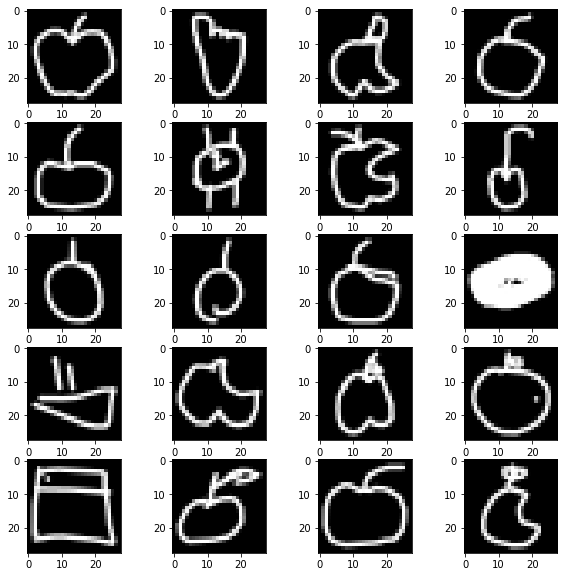

In [4]:
plot_4_by_4_images(load_dataset()[0])

# Training neural networks with HIDDEN activations

In [13]:
def apple_discriminator(hidden=None, output=None):

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1], name='input_disc'))
    
    if not hidden is None:
        model.add(Activation(hidden)) ##Change with respect to previous
    else:
        model.add(layers.ReLU())
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    
    if not hidden is None:
        model.add(Activation(hidden)) ##Change with respect to previous
    else:
        model.add(layers.ReLU())
        
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    if not output is None:
        model.add(layers.Dense(1, name='output_disc'))
        model.add(Activation(output))
    else:
        model.add(layers.Dense(1, activation='sigmoid', name='output_disc'))

    model.compile(loss='binary_crossentropy', 
                  optimizer='sgd',
                  metrics=['accuracy', 'TruePositives', 'TrueNegatives', 'FalseNegatives', 'FalsePositives', 'AUC'])
    return model


In [14]:
def log_to_file(t, filename = 'models/statistics.csv'):
    log = pd.read_csv(filename).values.tolist() if os.path.exists(filename) else []
    columns = ["Model Name", "Date", "Train Time", "Batch Size", "Epoch #", "Epochs", "Loss", "Accuracy", "True Positives", "True Negatives", 
           "False Positives", "False Negatives", "AUC", "Validation Loss", "Validation Accuracy", "Validation True Positives", "Validation True Negatives", 
           "Validation False Positives", "Validation False Negatives", "Validation AUC",]
    # If we have a list case type.
    if type(t[0]) == list:
        for i in t:
            log.append(i)
    # If we have a unique element
    else:
        log.append(t)
    pd.DataFrame(log, 
                 columns=columns).to_csv (filename, index = False, header=True)
    

def train_model(model_name, X_train, Y_train, X_test, Y_test, batch_size, epochs, hidden=None, output=None):
    global log
    reset_seed()
    
    create_dir('models/%s' % (model_name))
    model =  apple_discriminator(hidden, output)
    tic = time.time()
    print(model.summary())
    return
    history_callback = model.fit(x=X_train, y=Y_train, 
              batch_size=batch_size, epochs=epochs, verbose=1,
              validation_data=(X_test, Y_test))
    toc = time.time()
    #print(history_callback.history)
    print([v for k, v in history_callback.history.items()])
    date = datetime.now()
    date_str = "%02d/%02d/%02d %02d:%02d" % (date.day, date.month, date.year, date.hour + 2, date.minute)
    t = [[model_name, date_str, toc - tic, batch_size, epoch_num, epochs, ] + [v[epoch_num] for k, v in history_callback.history.items()] for epoch_num in range(epochs)]
                                                                   
    log_to_file(t, filename = 'v3_statistics.csv')

    model.save('models/%s/apple_discriminator.h5' % (model_name))
    
def benchmark_model(model_name, X_train, Y_train, X_test, Y_test, batch_size, epochs, rounds=10, hidden=None, output=None):
    global log
    for i in range(1, rounds+1):
        train_model(model_name, X_train, Y_train, X_test, Y_test, batch_size, 1, hidden, output)

    

In [8]:
X, Y = load_dataset()
train_test = X.shape[0] // 100 * 95
X_train, X_test = X[:train_test], X[train_test:]
Y_train, Y_test = Y[:train_test], Y[train_test:]
print(X_train.shape, X_test.shape)

(289468, 28, 28, 1) (289468,)
(274930, 28, 28, 1) (14538, 28, 28, 1)


## Base Model
This is the base benchmark model. It makes use of activations which are not

In [8]:
train_model('v2_base', X_train, Y_train, X_test, Y_test, batch_size=32, epochs=10, hidden=None, output=None)
#benchmark_model('base', X_train, Y_train, X_test, Y_test, batch_size=32, epochs=10, hidden=None, output=None)

Directory  models/v2_base  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 105s 380us/sample - loss: 0.1933 - acc: 0.9380 - true_positives: 129185.0000 - true_negatives: 128696.0000 - false_negatives: 8286.0000 - false_positives: 8763.0000 - auc: 0.9759 - val_loss: 0.1482 - val_acc: 0.9549 - val_true_positives: 6899.0000 - val_true_negatives: 6984.0000 - val_false_negatives: 352.0000 - val_false_positives: 303.0000 - val_auc: 0.9817
Epoch 2/10
274930/274930 [==============================] - 103s 375us/sample - loss: 0.1379 - acc: 0.9578 - true_positives: 130659.0000 - true_negatives: 132677.0000 - false_negatives: 6812.0000 - false_positives: 4782.0000 - auc: 0.9845 - val_loss: 0.1277 - val_acc: 0.9620 - val_true_positives: 6864.0000 - val_true_negatives: 7121.0000 - val_false_negatives: 387.0000 - val_false_positives: 166.0000 - val_auc: 0.9861
Epoch 3/10
274930/274930 [==============================] - 103

## Using the square function (Most Efficient) (only hidden)
In the code below, we train the adversarial network making use of the square function as activation function. It provides the advantage that it is really efficient in the "encrypted" domain, however, the results do not seem to be promising or the neural network to be learning.

Although it seems to work, at times, the exploding gradient problem comes. Due to the fact that the $x^2$ squares numbers, all numbers inbetween 0 and 1 get reduced ($-1 <= x <= 1$), but numbers bigger than 1 ($x > 1$) or smaller than -1 ($x < -1$) , get highly increased.


In [9]:
train_model('v2_square', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=square_activation, output=None)
#benchmark_model('square', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=square_activation, output=None)

Directory  models/v2_square  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 107s 391us/sample - loss: 0.4227 - acc: 0.7660 - true_positives_2: 109910.0000 - true_negatives_2: 100680.0000 - false_negatives_2: 27561.0000 - false_positives_2: 36779.0000 - auc_2: 0.8758 - val_loss: 0.1527 - val_acc: 0.9515 - val_true_positives_2: 6922.0000 - val_true_negatives_2: 6911.0000 - val_false_negatives_2: 329.0000 - val_false_positives_2: 376.0000 - val_auc_2: 0.9825
Epoch 2/10
274930/274930 [==============================] - 107s 388us/sample - loss: 0.1481 - acc: 0.9534 - true_positives_2: 130356.0000 - true_negatives_2: 131749.0000 - false_negatives_2: 7115.0000 - false_positives_2: 5710.0000 - auc_2: 0.9836 - val_loss: 0.1206 - val_acc: 0.9629 - val_true_positives_2: 6891.0000 - val_true_negatives_2: 7108.0000 - val_false_negatives_2: 360.0000 - val_false_positives_2: 179.0000 - val_auc_2: 0.9882
Epoch 3/10
274930/2

## Using the Taylor polynomial approximation for sigmoid (only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [10]:
train_model('v2_taylor_sigmoid', X_train, Y_train,
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_sigmoid, output=None)
# benchmark_model('taylor_sigmoid', X_train, Y_train,
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=taylor_sigmoid, output=None)

Directory  models/v2_taylor_sigmoid  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 152s 553us/sample - loss: 0.4332 - acc: 0.7692 - true_positives_4: 106803.0000 - true_negatives_4: 104669.0000 - false_negatives_4: 30668.0000 - false_positives_4: 32790.0000 - auc_4: 0.8735 - val_loss: 0.2023 - val_acc: 0.9316 - val_true_positives_4: 6787.0000 - val_true_negatives_4: 6756.0000 - val_false_negatives_4: 464.0000 - val_false_positives_4: 531.0000 - val_auc_4: 0.9729
Epoch 2/10
274930/274930 [==============================] - 151s 549us/sample - loss: 0.1997 - acc: 0.9321 - true_positives_4: 128259.0000 - true_negatives_4: 127992.0000 - false_negatives_4: 9212.0000 - false_positives_4: 9467.0000 - auc_4: 0.9734 - val_loss: 0.1810 - val_acc: 0.9437 - val_true_positives_4: 6769.0000 - val_true_negatives_4: 6950.0000 - val_false_negatives_4: 482.0000 - val_false_positives_4: 337.0000 - val_auc_4: 0.9765
Epoch 3/10



## Using the Chebyshev approximation for sigmoid (only hidden layers)


In [11]:
train_model('v2_chebyshev_sigmoid', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_sigmoid, output=None)
# benchmark_model('chebyshev_sigmoid', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=chebyshev_sigmoid, output=None)

Directory  models/v2_chebyshev_sigmoid  already exists
Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 143s 520us/sample - loss: 0.4439 - acc: 0.7686 - true_positives_6: 107218.0000 - true_negatives_6: 104101.0000 - false_negatives_6: 30253.0000 - false_positives_6: 33358.0000 - auc_6: 0.8709 - val_loss: 0.2149 - val_acc: 0.9261 - val_true_positives_6: 6798.0000 - val_true_negatives_6: 6666.0000 - val_false_negatives_6: 453.0000 - val_false_positives_6: 621.0000 - val_auc_6: 0.9712
Epoch 2/10
274930/274930 [==============================] - 155s 564us/sample - loss: 0.2001 - acc: 0.9320 - true_positives_6: 128410.0000 - true_negatives_6: 127822.0000 - false_negatives_6: 9061.0000 - false_positives_6: 9637.0000 - auc_6: 0.9739 - val_loss: 0.1809 - val_acc: 0.9424 - val_true_positives_6: 6796.0000 - val_true_negatives_6: 6904.0000 - val_false_negatives_6: 455.0000 - val_false_positives_6: 383.0000 - val_auc_6: 0.9768
Epoch 3/


## Using the Taylor approximation for tanh (only hidden layers)


In [12]:
train_model('v2_taylor_tanh', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_tanh, output=None)
# benchmark_model('taylor_tanh', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=taylor_tanh, output=None)

Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 177s 644us/sample - loss: 0.1909 - acc: 0.9369 - true_positives_8: 128818.0000 - true_negatives_8: 128762.0000 - false_negatives_8: 8653.0000 - false_positives_8: 8697.0000 - auc_8: 0.9756 - val_loss: 0.1664 - val_acc: 0.9482 - val_true_positives_8: 6851.0000 - val_true_negatives_8: 6934.0000 - val_false_negatives_8: 400.0000 - val_false_positives_8: 353.0000 - val_auc_8: 0.9789
Epoch 2/10
274930/274930 [==============================] - 176s 639us/sample - loss: 0.1603 - acc: 0.9485 - true_positives_8: 129751.0000 - true_negatives_8: 131026.0000 - false_negatives_8: 7720.0000 - false_positives_8: 6433.0000 - auc_8: 0.9807 - val_loss: 0.1490 - val_acc: 0.9553 - val_true_positives_8: 6842.0000 - val_true_negatives_8: 7046.0000 - val_false_negatives_8: 409.0000 - val_false_positives_8: 241.0000 - val_auc_8: 0.9821
Epoch 3/10
274930/274930 [==============================] - 176s 


## Using the Chebyshev approximation for tanh (only hidden layers)


In [13]:
# The results are always NaN
# train_model('chebyshev_tanh', X_train, Y_train, 
#             X_test, Y_test, batch_size=32, epochs=10, 
#             hidden=chebyshev_tanh, output=None)
# benchmark_model('chebyshev_tanh', X_train, Y_train, 
#             X_test, Y_test, batch_size=32, epochs=10, 
#             hidden=chebyshev_tanh, output=None)

## Using the Taylor approximation for ReLU (only hidden layers)


In [14]:
train_model('v2_taylor_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=taylor_relu, output=None)
# benchmark_model('taylor_relu', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=taylor_relu, output=None)

Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 160s 583us/sample - loss: 0.2237 - acc: 0.9294 - true_positives_10: 128627.0000 - true_negatives_10: 126892.0000 - false_negatives_10: 8844.0000 - false_positives_10: 10567.0000 - auc_10: 0.9712 - val_loss: 0.1799 - val_acc: 0.9446 - val_true_positives_10: 6830.0000 - val_true_negatives_10: 6903.0000 - val_false_negatives_10: 421.0000 - val_false_positives_10: 384.0000 - val_auc_10: 0.9772
Epoch 2/10
274930/274930 [==============================] - 153s 556us/sample - loss: 0.1681 - acc: 0.9457 - true_positives_10: 129600.0000 - true_negatives_10: 130404.0000 - false_negatives_10: 7871.0000 - false_positives_10: 7055.0000 - auc_10: 0.9799 - val_loss: 0.1551 - val_acc: 0.9531 - val_true_positives_10: 6816.0000 - val_true_negatives_10: 7040.0000 - val_false_negatives_10: 435.0000 - val_false_positives_10: 247.0000 - val_auc_10: 0.9812
Epoch 3/10
274930/274930 [==================


## Using the Chebyshev approximation for ReLU (only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [15]:
train_model('v2_chebyshev_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_relu, output=None)
# benchmark_model('chebyshev_relu', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=chebyshev_relu, output=None)

Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 149s 540us/sample - loss: 0.3023 - acc: 0.8713 - true_positives_12: 120983.0000 - true_negatives_12: 118576.0000 - false_negatives_12: 16488.0000 - false_positives_12: 18883.0000 - auc_12: 0.9479 - val_loss: 0.1826 - val_acc: 0.9415 - val_true_positives_12: 6848.0000 - val_true_negatives_12: 6840.0000 - val_false_negatives_12: 403.0000 - val_false_positives_12: 447.0000 - val_auc_12: 0.9763
Epoch 2/10
274930/274930 [==============================] - 148s 538us/sample - loss: 0.1876 - acc: 0.9392 - true_positives_12: 129038.0000 - true_negatives_12: 129185.0000 - false_negatives_12: 8433.0000 - false_positives_12: 8274.0000 - auc_12: 0.9762 - val_loss: 0.1705 - val_acc: 0.9483 - val_true_positives_12: 6810.0000 - val_true_negatives_12: 6977.0000 - val_false_negatives_12: 441.0000 - val_false_positives_12: 310.0000 - val_auc_12: 0.9786
Epoch 3/10
274930/274930 [=================


## Using the Chebyshev approximation for ReLU with Sigmoid Derivative(only hidden layers)
In the code below, we train the adversarial network making use of the sigmoid taylor polynomial approximation.

In [16]:
train_model('v2_chebyshev_integral_relu', X_train, Y_train, 
            X_test, Y_test, batch_size=32, epochs=10, 
            hidden=chebyshev_integral_relu.as_function(), output=None)
# benchmark_model('chebyshev_integral_relu', X_train, Y_train, 
#            X_test, Y_test, batch_size=32, epochs=10, 
#            hidden=chebyshev_integral_relu, output=None)

Train on 274930 samples, validate on 14538 samples
Epoch 1/10
274930/274930 [==============================] - 128s 467us/sample - loss: 0.3118 - acc: 0.8604 - true_positives_14: 119218.0000 - true_negatives_14: 117323.0000 - false_negatives_14: 18253.0000 - false_positives_14: 20136.0000 - auc_14: 0.9430 - val_loss: 0.1784 - val_acc: 0.9424 - val_true_positives_14: 6854.0000 - val_true_negatives_14: 6847.0000 - val_false_negatives_14: 397.0000 - val_false_positives_14: 440.0000 - val_auc_14: 0.9773
Epoch 2/10
274930/274930 [==============================] - 128s 466us/sample - loss: 0.1863 - acc: 0.9397 - true_positives_14: 129106.0000 - true_negatives_14: 129241.0000 - false_negatives_14: 8365.0000 - false_positives_14: 8218.0000 - auc_14: 0.9763 - val_loss: 0.1685 - val_acc: 0.9497 - val_true_positives_14: 6814.0000 - val_true_negatives_14: 6993.0000 - val_false_negatives_14: 437.0000 - val_false_positives_14: 294.0000 - val_auc_14: 0.9792
Epoch 3/10
274930/274930 [=================

In [17]:
results = pd.read_csv('v2_statistics.csv')
results

,Model Name,Date,Train Time,Batch Size,Epoch #,Epochs,Loss,Accuracy,True Positives,True Negatives,False Positives,False Negatives,AUC,Validation Loss,Validation Accuracy,Validation True Positives,Validation True Negatives,Validation False Positives,Validation False Negatives,Validation AUC
0,v2_base,20/05/2020 17:44,1032.312572,32,0,10,0.193274,0.937988,129185.0,128696.0,8286.0,8763.0,0.975928,0.148214,0.954946,6899.0,6984.0,352.0,303.0,0.981709
1,v2_base,20/05/2020 17:44,1032.312572,32,1,10,0.137901,0.957829,130659.0,132677.0,6812.0,4782.0,0.984535,0.127727,0.961962,6864.0,7121.0,387.0,166.0,0.986130
2,v2_base,20/05/2020 17:44,1032.312572,32,2,10,0.124287,0.962041,131187.0,133307.0,6284.0,4152.0,0.987020,0.117354,0.964920,6905.0,7123.0,346.0,164.0,0.988059
3,v2_base,20/05/2020 17:44,1032.312572,32,3,10,0.117940,0.963522,131345.0,133556.0,6126.0,3903.0,0.988173,0.112167,0.965676,6924.0,7115.0,327.0,172.0,0.988916
4,v2_base,20/05/2020 17:44,1032.312572,32,4,10,0.113010,0.965344,131613.0,133789.0,5858.0,3670.0,0.989012,0.108169,0.966020,6966.0,7078.0,285.0,209.0,0.989690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,v2_chebyshev_integral_relu,20/05/2020 20:33,1279.280830,32,5,10,0.148348,0.953224,130407.0,131663.0,7064.0,5796.0,0.983326,0.138342,0.957903,6910.0,7016.0,341.0,271.0,0.984160
76,v2_chebyshev_integral_relu,20/05/2020 20:33,1279.280830,32,6,10,0.144349,0.954527,130534.0,131894.0,6937.0,5565.0,0.983994,0.135558,0.959623,6900.0,7051.0,351.0,236.0,0.984845
77,v2_chebyshev_integral_relu,20/05/2020 20:33,1279.280830,32,7,10,0.140448,0.955763,130682.0,132086.0,6789.0,5373.0,0.984788,0.129691,0.960380,6921.0,7041.0,330.0,246.0,0.985840
78,v2_chebyshev_integral_relu,20/05/2020 20:33,1279.280830,32,8,10,0.136328,0.957207,130838.0,132327.0,6633.0,5132.0,0.985326,0.128734,0.962443,6883.0,7109.0,368.0,178.0,0.986435


In [18]:
def test_posibilities(function, params):
    l = len(params)
    if l == 1:
        # If just one key remaining, we execute the function.
        k = list(params.keys())[0]
        for x in params[k]:
            function(x)
    else:
        # If we have many 
        params_copy = dict(params)
        k = list(params_copy).keys()
        params_copy.pop()

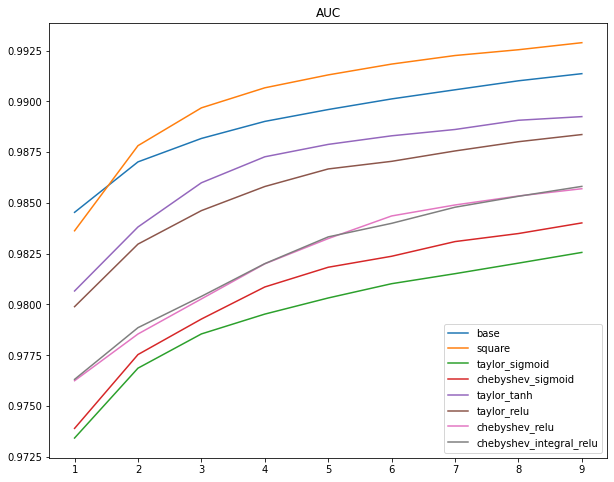

In [31]:
fig=plt.figure(figsize=(10, 8))
X = np.arange(1, 10, 1)
for i in range(8):
    plt.plot(X, results['AUC'][i*10 + 1: (i+1) * 10], label=results['Model Name'][i*10][3:])

plt.title('AUC')
plt.legend()
plt.show()
plt.close()

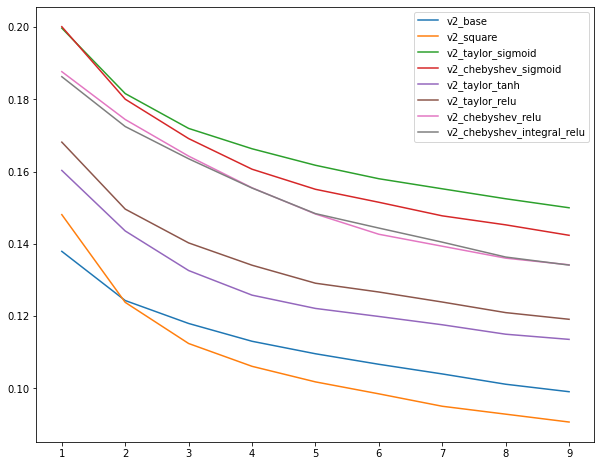

In [20]:
fig=plt.figure(figsize=(10, 8))
X = np.arange(1, 10, 1)
for i in range(8):
    plt.plot(X, results['Loss'][i*10 + 1: (i+1) * 10], label=results['Model Name'][i*10][3:])

plt.legend()
plt.show()
plt.close()

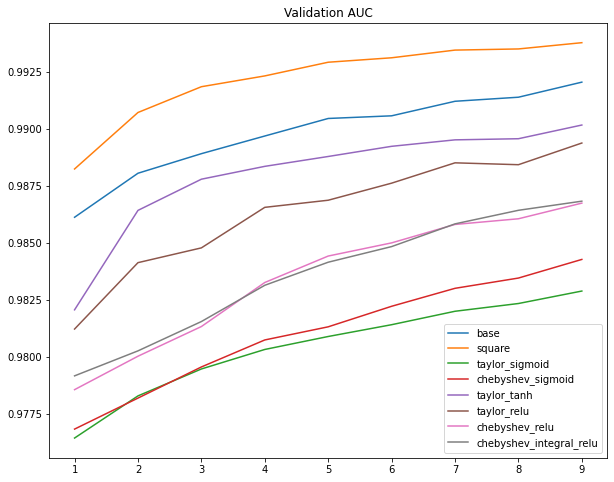

In [25]:
fig=plt.figure(figsize=(10, 8))
X = np.arange(1, 10, 1)
for i in range(8):
    plt.plot(X, results['Validation AUC'][i*10 + 1: (i+1) * 10], label=results['Model Name'][i*10][3:])

plt.title('Validation AUC')
plt.legend()
plt.show()
plt.close()

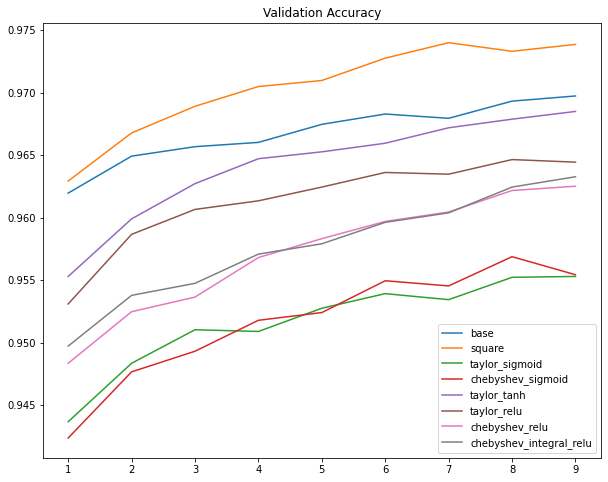

In [27]:
fig=plt.figure(figsize=(10, 8))
X = np.arange(1, 10, 1)
for i in range(8):
    plt.plot(X, results['Validation Accuracy'][i*10 + 1: (i+1) * 10], label=results['Model Name'][i*10][3:])

plt.title('Validation Accuracy')
plt.legend()
plt.show()
plt.close()

### Model Print
$P(t \mid c) = \frac{e^{\theta_t^T e_c}}{\sum_{t’=1}^{10000} e^{\theta_{t’}^Te_c}}$

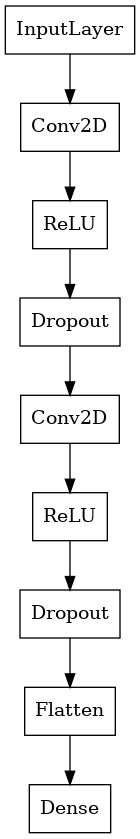

In [5]:
def print_model():

    model = tf.keras.models.load_model('models/v2_base/apple_discriminator.h5')
    return tf.keras.utils.plot_model(model, to_file='model_pic.png', show_shapes=False, show_layer_names=False)
print_model()

In [37]:
!pip install graphviz

You should consider upgrading via the '/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/bin/python3 -m pip install --upgrade pip' command.


# Private inference

In [28]:
def private_pred2(model, x):
    custom_functions = {'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    discriminator = tf.keras.models.load_model('models/%s/apple_discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    #print_nodes()
    print("Loaded %s model    " % (model))
        # Save model as PB
    save_model(tf.compat.v1.keras.backend.get_session(), 
               ["output_disc/BiasAdd"], "./models/%s/"%(model), 
               model)

    
    # Reset again the default graph
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)

    
    tf.import_graph_def(load_pb_file("./models/%s/%s.pb"%(model, model)))  
    
    x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input_disc_input:0')
    y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output_disc/BiasAdd:0')
    print_nodes()
    config = get_config_for_ngraph_server(x_input.name)
    with tf.compat.v1.Session(config=config) as sess:
        print("Executing new comp")
        sess.run(tf.compat.v1.global_variables_initializer())
        start_time = time.time()
        y_hat = y_output.eval(feed_dict={x_input: x })
        y_pred = np.tanh(y_hat)
        elasped_time = time.time() - start_time
        print("Total time(s)", np.round(elasped_time, 3))
        return y_pred
y_pred = private_pred2('v2_square', np.random.normal(0, 1, [1, 28, 28, 1]))    

Loaded v2_square model    


NameError: name 'save_model' is not defined

In [ ]:
%%time
y_pred = private_pred2('v2_square', np.random.normal(0, 1, [1, 28, 28, 1]))    

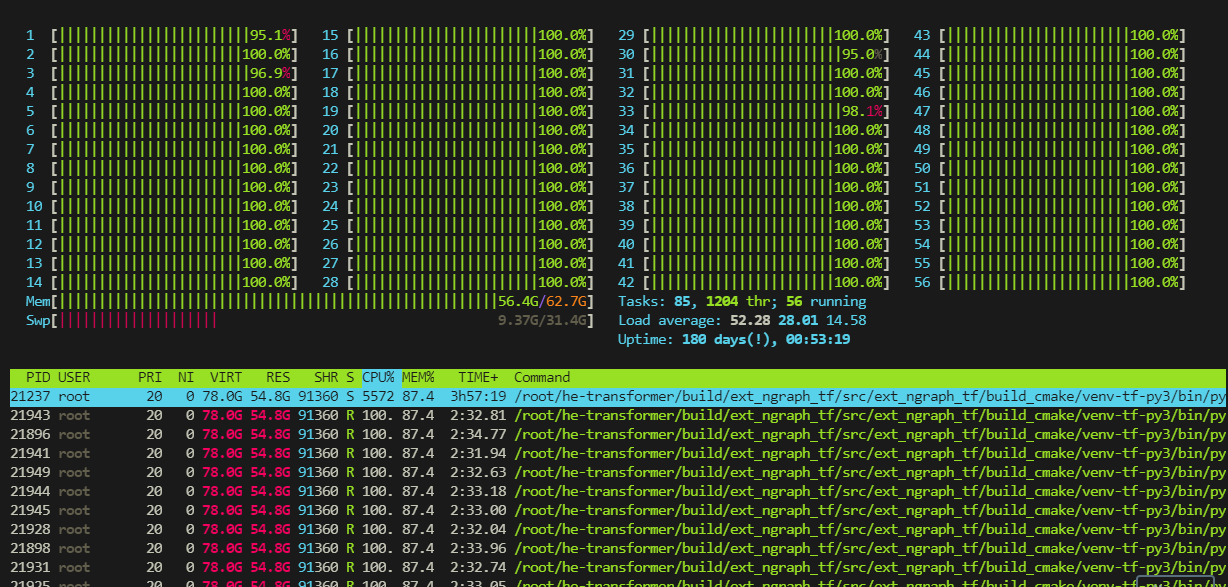

## Trying to simplify the model

# Looking inside the activations

In this section, we try to take a look at the inner part of the activation functions

In [ ]:
discriminator = None, None

def my_event_handler(btn_object):
    global generator, discriminator
    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'chebyshev_relu': chebyshev_relu,
                        'chebyshev_tanh': chebyshev_tanh.as_function(),
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    # generator = tf.keras.models.load_model('models/%s/apple_discriminator.h5' % (model), 
    #                                       custom_objects=custom_functions)
    
    discriminator = tf.keras.models.load_model('models/%s/apple_discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()   

In [ ]:
def print_intermediate_steps(model, test_activations, layer_interval):
    layer_outputs = [layer.output for layer in model.layers[layer_interval[0]:layer_interval[1]]]
    activation_model = Model(inputs=model.input,outputs=layer_outputs)
    activations = activation_model.predict(test_activations)
    #print("·$")
    layer_names = []
    for layer in model.layers[layer_interval[0]:layer_interval[1]]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        #print("Layer: %s" %(layer_name))
        try:
            if not ('activation' in layer_name or 
                    'conv' in layer_name or
                    're_lu' in layer_name or
                    'input_disc' in layer_name or 
                    'output_gen' in layer_name):
                continue
            n_features = layer_activation.shape[-1] # Number of features in the feature map
            size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
            n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            for col in range(n_cols): # Tiles each filter into a big horizontal grid
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                     :, :,
                                                     col * images_per_row + row]
                    channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, # Displays the grid
                                 row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
        except (RuntimeError):
            print("ERROR ON LAYER: %s" % (layer_name))
            print(RuntimeError)


In [ ]:
real_dataset = preprocess_real_samples(np.load('apple.npy'))


In [ ]:
noise = np.random.normal(0, 1, (1, 100))

In [ ]:
generator.summary()
print_intermediate_steps(generator, noise, (4, 10))

In [ ]:
discriminator.summary()
print_intermediate_steps(discriminator, X_train[0:1], (0, 8))

In [ ]:
def my_event_handler(btn_object):

    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
    print_intermediate_steps(generator, noise, (4, 10))
    
    print_intermediate_steps(discriminator, real_dataset[3:10], (0, 8))
    


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()   